In [1]:
import os
os.chdir('../../')

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp

from utilities import plot,errors
from datetime import datetime

import tensorflow_probability.substrates.jax as tfp
import jax.numpy as jnp
import jax
dist = tfp.distributions
from utilities import recalibration
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [3]:
from probml_utils import savefig, latexify
os.environ['CUDA_VISIBLE_DEVICES']=str(2)
os.environ['LATEXIFY']="1"
os.environ["FIG_DIR"]='FIGURES'

In [4]:
os.chdir('notebooks/dishwasher')

In [5]:

s2p_mlp_training = pd.read_csv('s2p/mlp/training_predictions.csv')
s2p_mlp_testing = pd.read_csv('s2p/mlp/testing_predictions.csv')
s2p_gmlp_training = pd.read_csv('s2p/gmlp/training_predictions.csv')
s2p_gmlp_testing = pd.read_csv('s2p/gmlp/testing_predictions.csv')

In [6]:
lstm_mlp_training = pd.read_csv('lstm/mlp/training_predictions.csv')
lstm_mlp_testing = pd.read_csv('lstm/mlp/testing_predictions.csv')
lstm_gmlp_training = pd.read_csv('lstm/gmlp/training_predictions.csv')
lstm_gmlp_testing = pd.read_csv('lstm/gmlp/testing_predictions.csv')


In [7]:

s2p_mlp_recal = pd.read_csv('s2p/mlp/recalibration_df.csv')
s2p_gmlp_recal = pd.read_csv('s2p/gmlp/recalibration_df.csv')
lstm_mlp_recal=pd.read_csv('lstm/mlp/recalibration_df.csv')
lstm_gmlp_recal=pd.read_csv('lstm/gmlp/recalibration_df.csv')

In [8]:
s2p_mlp_training.columns = map(str.lower, s2p_mlp_training.columns)
s2p_mlp_testing.columns = map(str.lower, s2p_mlp_testing.columns)
s2p_gmlp_training.columns = map(str.lower, s2p_gmlp_training.columns)
s2p_gmlp_testing.columns = map(str.lower, s2p_gmlp_testing.columns)
lstm_mlp_training.columns = map(str.lower, lstm_mlp_training.columns)
lstm_mlp_testing.columns = map(str.lower, lstm_mlp_testing.columns)
lstm_gmlp_training.columns = map(str.lower, lstm_gmlp_training.columns)
lstm_gmlp_testing.columns = map(str.lower, lstm_gmlp_testing.columns)

In [10]:
os.chdir("../../")

In [11]:
latexify(fig_width=7, fig_height=1.5)

In [19]:
def load_model(recab):
    p=recab['p'].iloc[949]
    new_p=recab['new_p_mc'].iloc[949]
    ori_std_factor=recalibration.mass_to_std_factor(p)
    new_std_factor=recalibration.mass_to_std_factor(new_p)
    return ori_std_factor,new_std_factor

def plot(timestamp, gt, mean, sigma, ori_std_factor, new_std_factor, idx1, idx2, p, p_hat, new_phat):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3)
    idx = jnp.where(
        (gt.values < mean.values + ori_std_factor * sigma.values)
        & (gt.values > mean.values - ori_std_factor * sigma.values)
    )[0]
    print(len(idx))
    ax1.plot(timestamp, gt.values, label="Ground Truth")
    ax1.plot(timestamp, mean.values, label="Mean",color="black")
    ax1.fill_between(
        timestamp,
        mean.values - ori_std_factor * sigma.values,
        mean.values + ori_std_factor * sigma.values,
        label=r"95\%",
        alpha=0.2,
        color="C1"
    )
    a=len(idx)
    ax1.scatter(timestamp.values[np.array(idx)], gt[jnp.arange(idx1,idx2)[idx]], label="Within", color="C1",s=10)
   
    h = ax1.legend(["Ground\nTruth", "Mean"], loc="upper right", fontsize=6)
    
    ax1.set_xticks(jnp.arange(0, idx2-idx1, 10), fontsize=2)
    ax1.tick_params(axis='x',rotation=90)

    
    idx = jnp.where(
        (gt.values < mean.values + new_std_factor * sigma.values)
        & (gt.values > mean.values - new_std_factor * sigma.values)
    )[0]
    print(len(idx))
    b=len(idx)
    ax2.plot(timestamp ,gt.values, label="Ground Truth")
    ax2.plot(timestamp, mean.values, label="Mean prediction",color="black")
    ax2.fill_between(
        timestamp,
        mean.values - new_std_factor * sigma.values,
        mean.values + new_std_factor * sigma.values,
        #label=rf"{100*mass:0.2f}% CI, $\mu \pm {std_factor:0.2f}\sigma$",
        alpha=0.2,
        color="C1"
    )
    ax2.scatter(timestamp.values[np.array(idx)], gt[jnp.arange(idx1,idx2)[idx]], label="Within", color="C1",s=10)
    ax2.set_xticks(jnp.arange(0, idx2-idx1, 10))
    ax2.tick_params(axis='x',rotation=90)
    red_patch = mpatches.Patch(color='C1',alpha=0.2, label='95\%')
    nine = mlines.Line2D([], [], color='C1', marker='o', ls='', label='Within', markersize=6)
    h = ax2.legend(handles=[red_patch, nine], loc="upper right", fontsize=6)


    ax3.plot(p,p,"--",color="black",label='ideal')
    ax3.plot(p,p_hat,"--",label='Uncalibrated')
    ax3.plot(p,new_phat,"--", label='Calibrated', color="green")
    ax3.legend(fontsize=6)
    ax1.set_ylabel("Watt")
    ax3.set_ylabel("$\hat{p}$")
    ax3.set_xlabel("p")
    plt.suptitle(f"LSTM HOMO DE, Before: {a}\%, After: {b}\%",fontweight="bold")
    ax1.set_ylabel("Watt")
    ax3.set_xlabel("p")
    ax3.set_ylabel("$\hat{p}$")
    sns.despine()


14


/tmp/ipykernel_1330/3689094901.py:31: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax1.set_xticks(jnp.arange(0, idx2-idx1, 10), fontsize=2)


26


/tmp/ipykernel_1330/3689094901.py:52: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax2.set_xticks(jnp.arange(0, idx2-idx1, 10))


saving image to FIGURES/fill_between_dishwasher_latexified.pdf
Figure size: [7.  1.5]


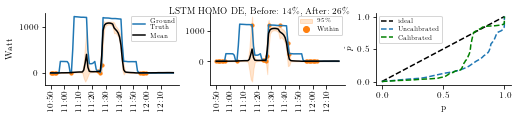

In [20]:
recal=lstm_mlp_recal
test=lstm_mlp_testing
idx1=4850
idx2=4940

timestamp = lstm_gmlp_testing["timestamp"][idx1:idx2]
timestamp = pd.to_datetime(timestamp).dt.strftime('%H:%M')

ori_std_factor,new_std_factor=load_model(recal)
gt=test["ground truth"][idx1:idx2]
mean=test["de_mean"][idx1:idx2]
sigma=test["de_sigma"][idx1:idx2]
p,phat,new_phat=recal['p'].values,recal['phat_de'].values,recal['new_phat_de'].values
plot(timestamp,gt,mean,sigma,ori_std_factor,new_std_factor,idx1,idx2,p,phat,new_phat)
savefig("fill_between_dishwasher", tight_bbox=True)